In [33]:
# Import external tools:
import time 
import random
from matplotlib import pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torchaudio
import soundfile as sf
from scipy import signal
import getpass
import pandas as pd
import numpy as np
import sys
import os
import importlib
from scipy.io import wavfile
from IPython.display import Audio
from datetime import datetime
from sklearn.manifold import TSNE

projectdir="/home/ubuntu/joanna/VAE-IR/"
datadir="/home/ubuntu/Data/"

# Add path of this project
sys.path.insert(0, projectdir+'src/')

# Import and automatically reload my own modules:
import sig2ir_datasetprep; importlib.reload(sig2ir_datasetprep)
import sig2ir_models; importlib.reload(sig2ir_models)

<module 'sig2ir_models' from '/home/ubuntu/joanna/VAE-IR/src/sig2ir_models.py'>

In [34]:
# --------------------- Model: ---------------------
FS=48000
SIG_LEN=int(2.73*FS)
L_LEN=512
V_LEN=400 
Z_LEN=512*2
IR_LEN=FS
DEVICE="cpu"

model=sig2ir_models.sig2ir_encdec(sig_len=SIG_LEN, l_len=L_LEN, v_len=V_LEN, z_len=Z_LEN, ir_len=IR_LEN,device=DEVICE)
train_results=torch.load(projectdir + "models/22-08-2023--13-15.pt",map_location=DEVICE)
model.load_state_dict(train_results["model_state_dict"])
model.eval()



sig2ir_encdec(
  (encode): sig2ir_encoder(
    (conv_layers): Sequential(
      (0): EncBlock(
        (direct_conv): Conv1d(1, 2, kernel_size=(15,), stride=(2,), padding=(7,))
        (direct_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (direct_prelu): PReLU(num_parameters=1)
        (residual_conv): Conv1d(1, 2, kernel_size=(1,), stride=(2,))
        (residual_bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): EncBlock(
        (direct_conv): Conv1d(2, 4, kernel_size=(15,), stride=(2,), padding=(7,))
        (direct_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (direct_prelu): PReLU(num_parameters=1)
        (residual_conv): Conv1d(2, 4, kernel_size=(1,), stride=(2,))
        (residual_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): EncBlock(
        (direct_conv): Conv1d(4, 8, kernel_si

In [69]:
# --------------------- Dataset: ---------------------

# Set random seed for NumPy, Pandas, and PyTorch
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set up sources of RIRs and audios for dataset
AUDIO_INFO_FILE = "/home/ubuntu/joanna/VAE-IR/audio_VCTK_datura.csv"
IR_INFO_FILE = "/home/ubuntu/joanna/VAE-IR/irstats_ARNIandBUT_datura.csv"

df_audiopool=pd.read_csv(AUDIO_INFO_FILE,index_col=0)
df_irs=pd.read_csv(IR_INFO_FILE,index_col=0)
df_irs=df_irs[df_irs["database_ir"]=="arni"]
df_irs=df_irs.sample(100)

# create a tag for dataset info file 
dataset=sig2ir_datasetprep.Dataset_SpeechInSpace(df_audiopool,df_irs,sr=FS, ir_len=FS*2, sig_len=int(FS*2.4), N_per_ir=1e4)
# split dataset into training set, test set and validation set
N_train = round(len(dataset) * 0.5)
N_rest = len(dataset) - N_train
trainset, restset = random_split(dataset, [N_train, N_rest])
N_test = round(len(restset) * 0.5)
N_val = len(restset) - N_test
testset, valset = random_split(restset, [N_test, N_val])

testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True, num_workers=1)

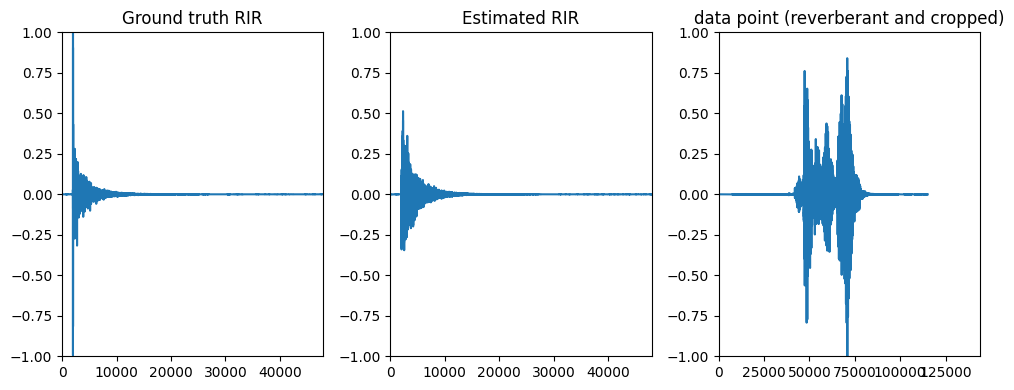

In [77]:
# Inspect a data point: 

sig, ir, dp, label=testset[np.random.randint(len(testset))]
ir_EST=model(dp.to(DEVICE))
ir_EST=ir_EST.squeeze(1).detach()
ir_GT=ir[:,:FS]

_, ir_GT_REF, dp_ref, _=testset[np.random.randint(len(testset))]
ir_EST_REF=model(dp_ref.to(DEVICE))
ir_EST_REF=ir_EST_REF.squeeze(1).detach()
ir_GT_REF=ir_GT_REF[:,:FS]

fig = plt.figure(figsize=(10, 4))
plt.subplot(1,3,1)
plt.plot(ir_GT.T)
plt.xlim((0,FS))
plt.ylim((-1,1))
plt.title('Ground truth RIR')

plt.subplot(1,3,2)
plt.plot(ir_EST.T)
plt.xlim((0,FS))
plt.ylim((-1,1))
plt.title('Estimated RIR')

plt.subplot(1,3,3)
plt.plot(dp.squeeze([0]).T)
plt.xlim((0,FS*3))
plt.ylim((-1,1))
plt.title('data point (reverberant and cropped)')
plt.tight_layout()
plt.show()


In [64]:
import scipy 
# load
sig_anechoic, sr = torchaudio.load(label["filepath_sig"])
# resample
sig_anechoic=torchaudio.transforms.Resample(sr,FS)(sig_anechoic)

sig_ir_GT = torch.from_numpy(scipy.signal.fftconvolve(sig_anechoic, ir_GT))
sig_ir_EST = torch.from_numpy(scipy.signal.fftconvolve(sig_anechoic, ir_EST))
sig_ir_REF = torch.from_numpy(scipy.signal.fftconvolve(sig_anechoic, ir_REF))

In [65]:
Audio(sig_anechoic,rate=FS)

In [66]:
Audio(sig_ir_GT,rate=FS)

In [67]:
Audio(sig_ir_EST,rate=FS)

In [68]:
Audio(sig_ir_REF,rate=FS)